#### Final Project: Rick & Morty analysis

# Phase 3: Exploring Data (Laurine)

In [152]:
# imports
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import codecs
import numpy as np

import seaborn as sns
sns.set()

## 1.3. Finding the “favourite words” of the Smith/Sanchez family

**Focus on characters: Rick Sanchez, Morty Smith, Beth Smith, Jerry Smith, Summer Smith**

### REPORT

What the Kaggle study found: https://www.kaggle.com/andradaolteanu/sentiment-analysis-rick-and-morty-scripts (see "most 10 words from the Smith family" plots)

#### 1st approach
- I only used the transcript database of the Kaggle study we found on Sentiment Analysis
- Pre-processing = lower case + exclude characters' name + NLTK tokenization + NLTK lemmatization + remove words with 2 letters or less

**CCL** : 
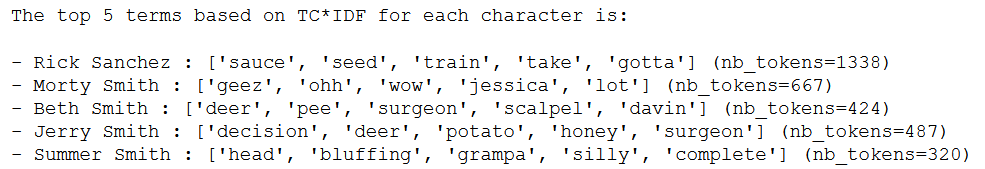

We clearly need more words, especially for Beth, Jerry and Summer! We identify the words from the first episode, when Beth is saving a shot deer.

## Generate data files (tokens)

In [2]:
# load data
df_transcripts = pd.read_csv('transcripts/RickAndMortyScripts.csv')
df_transcripts.head()

,season no.,episode no.,episode name,name,line
0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [58]:
to_search = "You think supporting the family is about supporting you emotionally"
df_transcripts[df_transcripts.line.str.contains(to_search)]

,season no.,episode no.,episode name,name,line
5043,2,3,Auto Erotic Assimilation,Beth,You think supporting the family is about suppo...


In [3]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)

In [149]:
rev_family_list = {v:k for k,v in family_list.items()}

In [4]:
from os import listdir
from os.path import isfile, join

import nltk
from nltk.tokenize import WordPunctTokenizer

In [5]:
# apply the tokenization process

pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

In [6]:
# get the stopwords list in given language
from gensim.parsing.preprocessing import STOPWORDS
stopwords = STOPWORDS
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = nltk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])
    # Save your output for future use
    # f = codecs.open('character_words_tokens/'+aFile, "w+", "utf-8")
    # f.write(character_page)
    # f.close()

## Overview of the whole family words

In [7]:
from nltk.corpus import PlaintextCorpusReader

In [8]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = nltk.Text(familyCorpus.words())

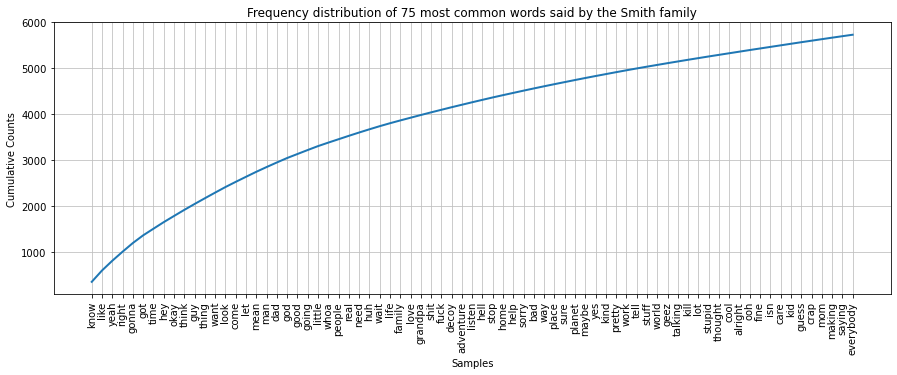

In [9]:
# get the freq distribution of tokens
fdist_family = nltk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

# NLTK stats and computations

In [106]:
def dic_reverse_sort(aDict):
    return dict(sorted(aDict.items(), reverse=True, key=lambda x:x[1]))

In [100]:
familyText.similar('family')

dad know life build god important old dunno day far dressed


In [82]:
familyText.common_contexts(['family','important'])
familyText.common_contexts(['family','life'])

think_love
time_friend


In [89]:
# study each character's words
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}
char_documents

{'Rick Sanchez': <Text: gotta come jus gotta come got surprise come...>,
 'Morty Smith': <Text: going middle night talking tugging hard yeah great...>,
 'Beth Smith': <Text: getting sick told practice kiss living room pillow...>,
 'Jerry Smith': <Text: new episode singing tonight guy think gonna best...>,
 'Summer Smith': <Text: god head food going puke maybe night grandpa...>}

In [109]:
# who is the most talkative
most_talkative = dic_reverse_sort({k:len(t)/len(familyText) for k,t in char_documents.items()})
most_talkative

{'Rick Sanchez': 0.5007924827351976,
 'Morty Smith': 0.21895165855315296,
 'Jerry Smith': 0.12702366127023662,
 'Summer Smith': 0.07902184988112759,
 'Beth Smith': 0.0742103475602853}

In [129]:
char_colors = {'Rick Sanchez':'#95e4f0', 'Morty Smith':'#f7ecb0','Jerry Smith':'#6fde8b','Summer Smith':'#e895de','Beth Smith':'#e8a2a2'}

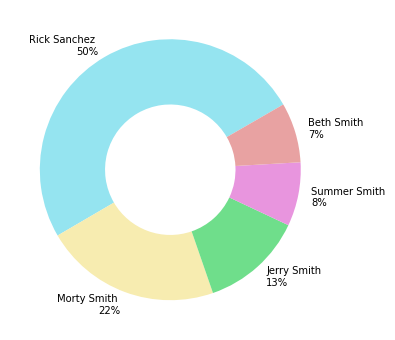

In [138]:
# plot most talkative : pie chart
plt.figure(figsize=(6,6))
font_color = 'k'
plt.pie(most_talkative.values(), 
           labels=['{} \n{}%'.format(k,round(100*v)) for k,v in most_talkative.items()], 
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts
           colors=[char_colors[k] for k in most_talkative.keys()],
           textprops={'color':font_color})
plt.show()

In [110]:
# compare lexical diversities

# functions from Natural Language Processing with Python (NLPP), Chapter 1.4
def lexical_diversity(text):
    return len(set(text)) / len(text)

print("Overall lexical diversity: ", lexical_diversity(familyText))

compare_lexical_diversity = dic_reverse_sort({k:lexical_diversity(v) for k,v in char_documents.items()})
compare_lexical_diversity

Overall lexical diversity:  0.2345182837088192


{'Summer Smith': 0.5286532951289399,
 'Beth Smith': 0.528604118993135,
 'Jerry Smith': 0.4768270944741533,
 'Morty Smith': 0.3518614270941055,
 'Rick Sanchez': 0.3227082626879168}

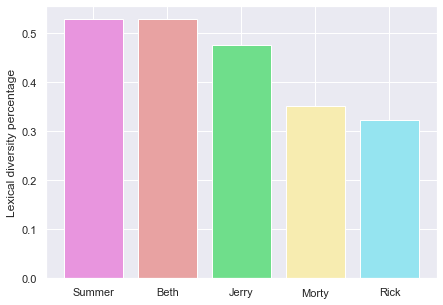

In [159]:
x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,compare_lexical_diversity.values(),color=[char_colors[k] for k in compare_lexical_diversity.keys()])
plt.xticks(x,[rev_family_list[k] for k in compare_lexical_diversity.keys()])
plt.ylabel('Lexical diversity percentage')

plt.show()

## The favourites words of each character from the Smith family >> TC-IDF

Why TC? Better to plot wordclouds later.

In [10]:
# get one document (of tokens) per character
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [11]:
# compute the TC of each character
char_fdist = {aCharacter:nltk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

The top 5 terms for each character is:

- Rick Sanchez : ['know', 'gonna', 'right', 'like', 'yeah']
- Morty Smith : ['know', 'like', 'right', 'yeah', 'gonna']
- Beth Smith : ['dad', 'know', 'okay', 'like', 'want']
- Jerry Smith : ['know', 'like', 'hey', 'guy', 'okay']
- Summer Smith : ['grandpa', 'god', 'yeah', 'like', 'dad']


In [12]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [13]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

The top 5 terms based on TC*IDF for each character is:

- Rick Sanchez : ['sauce', 'number', 'bunch', 'season', 'piece'] (nb_tokens=2855)
- Morty Smith : ['ohh', 'duane', 'geez', 'ohhhh', 'bawk'] (nb_tokens=1361)
- Beth Smith : ['surgeon', 'cling', 'performing', 'surgery', 'davin'] (nb_tokens=693)
- Jerry Smith : ['apple', 'pluto', 'tru', 'award', 'potato'] (nb_tokens=1070)
- Summer Smith : ['drum', 'needful', 'bluffing', 'nancy', 'ethan'] (nb_tokens=738)


# Word clouds

In [14]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [15]:
def plot_wordcloud(chosen_element, documents_dic, TC_IDF_dic, aMaskFileName, aFigure):
    """ 
    Generate N wordclouds (based on given chosen_elements) using 
    - documents_dic {aKey:aDocument},
    - TC_IDF_dic {aKey{aWord:aScore}},
    in the matplotlib.pyplot Figure (aFigure) with a fancy mask (aMaskFileName) if wanted
    """
    if aMaskFileName != None:
        mask = np.array(Image.open(aMaskFileName))
    
    # Adjust the number of occurrences of each word based on TC-IDF
    list_to_wordcloud = []
    for aTerm in list(documents_dic[chosen_element]):
        multiplicator = round(TC_IDF_dic[chosen_element][aTerm])
        list_to_wordcloud = list_to_wordcloud + multiplicator*[aTerm]
        
    # Generate a word cloud image
    if aMaskFileName != None:
        wordcloud = WordCloud(background_color="white", mask=mask, collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        aFigure.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        wordcloud = WordCloud(background_color="white", collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        aFigure.imshow(wordcloud, interpolation='bilinear')   
    aFigure.set_title(chosen_element, size=15)
    aFigure.axis("off")

In [16]:
# get masks for plots
url_base_masks = "masks/"
all_masks = ["rick_blue.png", "morty_yellow.png", "beth_red.png", "jerry_green.png", 'summer_pink.png']
all_masks = [ url_base_masks+aMaskFileName for aMaskFileName in all_masks ]

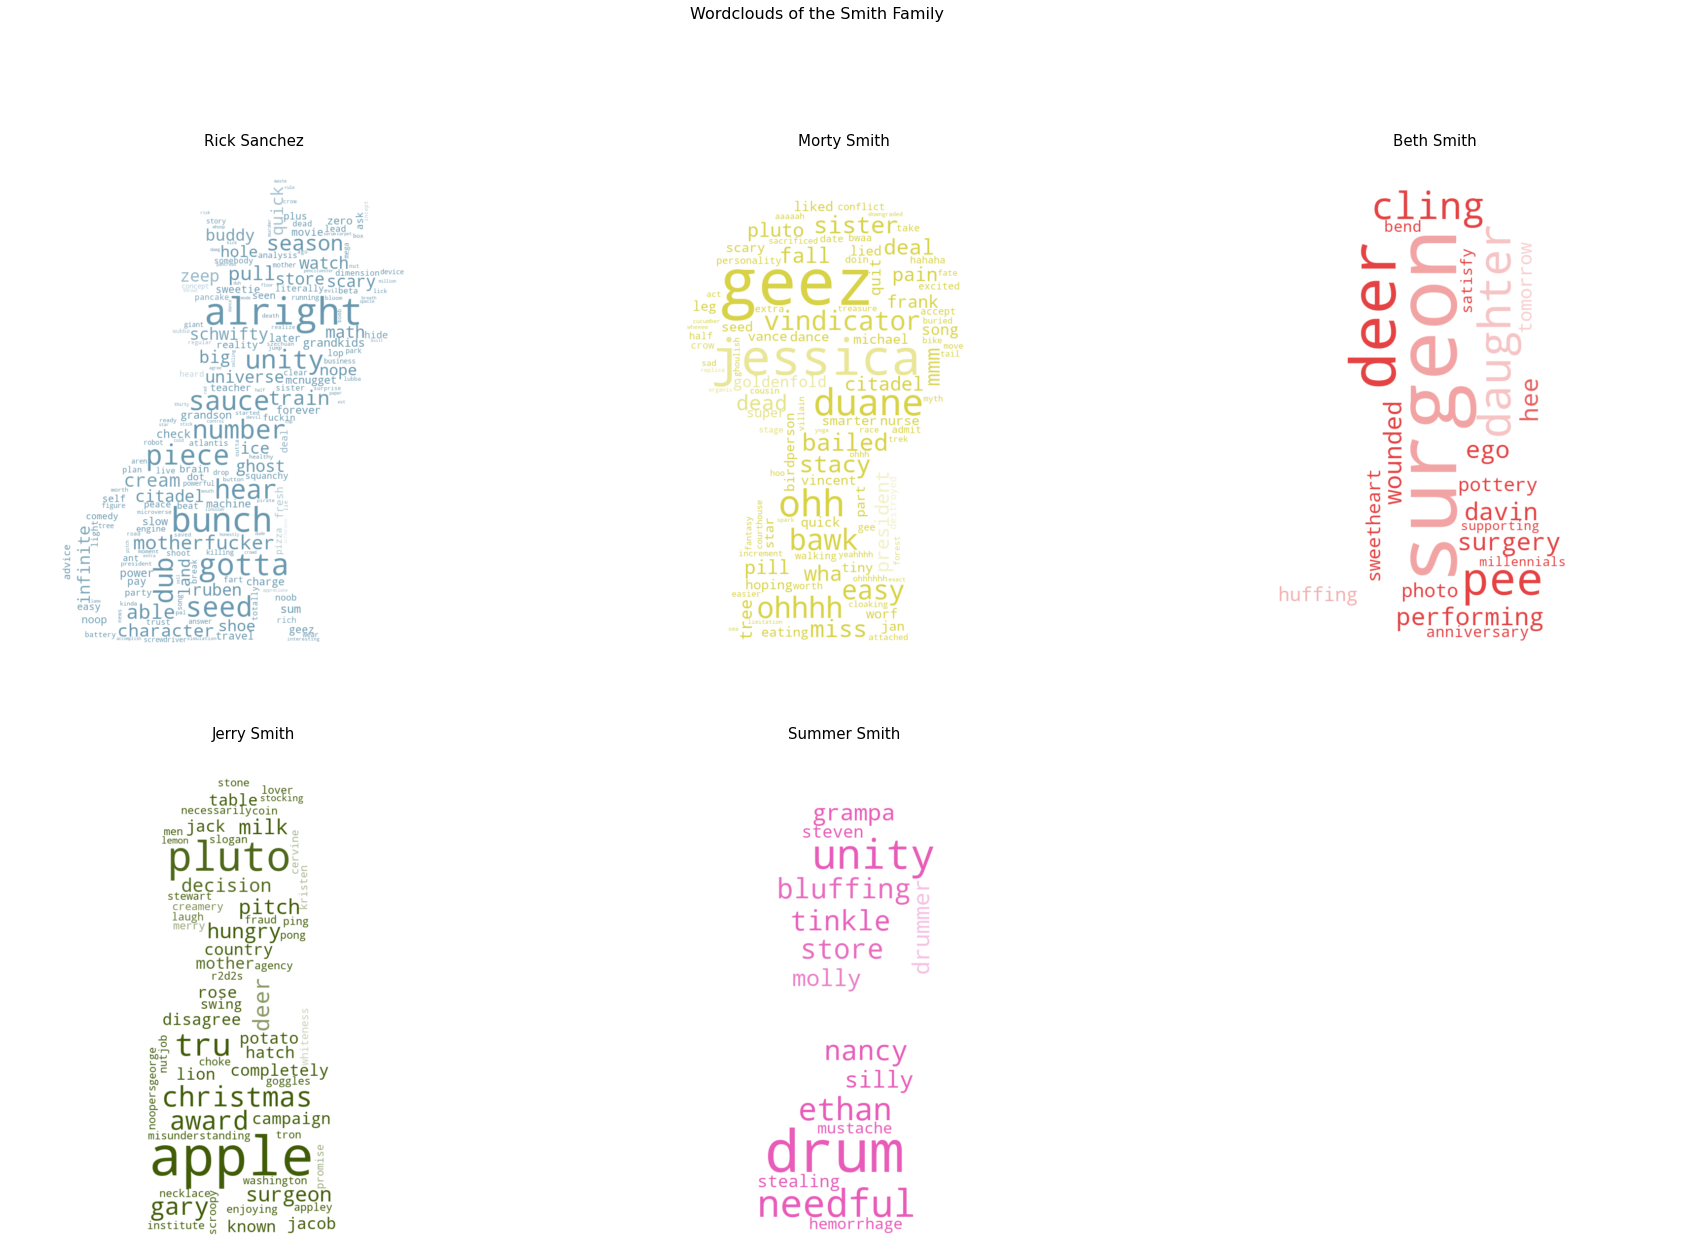

In [17]:
# plot wordclouds
fig, axes = plt.subplots(2,3,figsize=(30,20), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle("Wordclouds of the Smith Family", fontsize=16)

for i,ax in enumerate(axes.flat):
    if i<5:
        plot_wordcloud(list(family_list.values())[i], char_documents, family_TC_IDF, all_masks[i], ax)
    else:
        ax.set_visible(False)
plt.show()

# Get bigrams

In [18]:
def get_50_most_frequent_bigrams_not_stopwords(aText, language = 'english', top_nb = 50):
    """Get  the 50 most most frequent bigrams of a text that are not stopwords. 
    By default, the text is in English"""
    # get the stopwords list in given language
    stopwords = nltk.corpus.stopwords.words(language)
    # drop stopwords from text and punctuation
    content = nltk.Text([w for w in aText if w.lower() not in stopwords and w.isalnum()])
    # get bigrams
    bigrams_list = list(nltk.bigrams(content))
    # compute frequency distribution for bigrams
    fdist_bigrams = nltk.FreqDist([a+' '+b for (a,b) in bigrams_list])
    # return 50 most common bigrams
    return fdist_bigrams.most_common(top_nb)

In [19]:
for aCharacter in family_list.values():
    print("For "+aCharacter+' : ')
    print(get_50_most_frequent_bigrams_not_stopwords(char_documents[aCharacter], top_nb=5))

For Rick Sanchez : 
[('look like', 19), ('whoa whoa', 15), ('portal gun', 10), ('yeah yeah', 10), ('ice cream', 8)]
For Morty Smith : 
[('yeah know', 8), ('know mean', 8), ('hey know', 7), ('holy crap', 5), ('know right', 5)]
For Beth Smith : 
[('holy crap', 3), ('open door', 3), ('decoy family', 3), ('way dad', 2), ('time life', 2)]
For Jerry Smith : 
[('pluto planet', 7), ('planet planet', 6), ('whoa whoa', 5), ('sleepy gary', 5), ('look like', 4)]
For Summer Smith : 
[('god god', 6), ('ooh ooh', 6), ('drum drum', 5), ('dad like', 3), ('yes yes', 3)]


# Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?

Use of NRC lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [20]:
df_NRC = pd.read_csv('lexicons/NRC_sentiment_lexicon.csv')
df_NRC_VAD = pd.read_csv('lexicons/NRC-VAD-Lexicon.csv')

In [21]:
def combine_lines(aDataFrame):
    result = ''
    for _, aRow in aDataFrame.iterrows():
        result += aRow.line+' '
    return result

def get_word_tokens(aTextOfLines):
    """ Lower + tokenization + remove punctuation """
    # Set to lower case
    aTextOfLines = aTextOfLines.lower()
    # Tokenize
    tokens = tk.tokenize(aTextOfLines)
    # Remove punctuation
    tokens = [aToken for aToken in tokens if aToken.isalnum()]
    # Lemmatize 
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def analyse_text_NRC(aText, aDF = None):
    """ Get the NRC sentments + VAD scores of a given text (aText)
    Output : dict of VAD scores / dict of sentiments scores / tokens / text """
    tokens = get_word_tokens(aText)
    
    result_sentiments_df = df_NRC[df_NRC.Word.isin(tokens)]
    result_VAD_df = df_NRC_VAD[df_NRC_VAD.Word.isin(tokens)]
    
    result_sentiments_dict = result_sentiments_df.sum().drop('Word')/len(result_sentiments_df)
    result_VAD_dict = result_VAD_df.sum().drop('Word')/len(result_VAD_df)
    result_sentiments_dict = dict(sorted(result_sentiments_dict.items(), reverse=True, key=lambda x:x[1]))
    result_VAD_dict = dict(sorted(result_VAD_dict.items(), reverse=True, key=lambda x:x[1]))
    
    return {'VAD scores':result_VAD_dict, 'sentiment scores':result_sentiments_dict, 'tokens':tokens, 'lines':aText, 'df':aDF}

def get_df_substract(source_char, target_char):
    return df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(target_char))]

def analyse_interactions_NRC(source_char, target_char):
    """ Get the NRC sentiments + VAD scores when source_char talk to target_char """
    df = get_df_substract(source_char, target_char)
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def analyse_one_char_words(source_char):
    """ Get the NRC sentiments + VAD scores for only source_char lines """
    df = df_transcripts[df_transcripts.name==source_char]
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def get_text_of(source,target=None):
    if target==None:
        df = df_transcripts[df_transcripts.name==source]
        return combine_lines(df)
    df = get_df_substract(source, target)
    return combine_lines(df)

Detail of VAD sentiments:
- valence: from NEGATIVE/DISPLEASURE to POSITIVE/PLEASURE
- arousal: from CALM/PASSIVE to EXCITED/ACTIVE
- dominance: FROM WEAK/CONTROLLED to POWERFUL/CONTROL

Detail of NRC sentiments: anger, fear, anticipation, trust, surprise, sadness, joy, or disgust

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# generate all lexicons
all_lexicons = {}
for element in ['Arousal','Dominance','Valence']:
    all_lexicons[element]= {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC_VAD[['Word',element]].iterrows()}
for element in df_NRC.drop('Word',axis=1).columns:
    all_lexicons[element] = {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC[['Word',element]].iterrows()}
all_lexicons['Valence_VADER']= SentimentIntensityAnalyzer().lexicon

### For interactions 'source', 'target'

In [22]:
df_family_interactions = pd.read_csv('family_interactions_sentiment_scores.csv')

In [31]:
df_family_interactions.head()

,Source,Target,Nb_tokens,Arousal,Dominance,Valence,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,Valence_VADER
0,Rick,Morty,10607,-1.0000,1.0000,1.0000,-0.9998,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.9999
1,Rick,Beth,670,-0.9998,-0.8782,0.9999,-0.9960,-0.9984,-0.9999,-0.9997,-0.9998,-0.9999,-0.9998,-0.9998,-0.9998,-0.9998,0.9882
2,Rick,Jerry,1303,-0.9999,0.9957,0.9999,-0.9988,-0.9995,-0.9999,-0.9999,-0.9999,-0.9999,-0.9999,-0.9999,-0.9999,-0.9998,0.7990
3,Rick,Summer,627,-0.9995,0.9946,0.9999,-0.9964,-0.9921,-0.9997,-0.9997,-0.9998,-0.9998,-0.9997,-0.9998,-0.9997,-0.9984,-0.9131
4,Morty,Rick,4298,-1.0000,0.9998,1.0000,-0.9999,-0.9998,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.9985


### For characters only

In [40]:
# save as csv
df_family_individual_sentiment_scores.to_csv('family_individual_sentiment_scores.csv',index=False)

In [41]:
df_family_individual_sentiment_scores = pd.read_csv('family_individual_sentiment_scores.csv')

In [42]:
df_family_individual_sentiment_scores.head()

,Character,Nb_tokens,Arousal,Dominance,Valence,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,Valence_VADER
0,Rick,23960,-1.0000,1.0000,1.0,-1.0000,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0000
1,Morty,11236,-1.0000,1.0000,1.0,-1.0000,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.9999
2,Beth,3738,-1.0000,1.0000,1.0,-0.9998,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.9998
3,Jerry,5985,-1.0000,0.9999,1.0,-0.9997,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0000
4,Summer,3705,-0.9999,0.9999,1.0,-0.9994,-0.9999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.9994


### Analyse

In [47]:
emotion='Dominance'
df_family_interactions.sort_values(emotion,ascending=False)[['Nb_tokens','Source','Target',emotion]]

,Nb_tokens,Source,Target,Dominance
0,10607,Rick,Morty,1.0000
4,4298,Morty,Rick,0.9998
6,619,Morty,Summer,0.9961
2,1303,Rick,Jerry,0.9957
13,473,Jerry,Beth,0.9957
3,627,Rick,Summer,0.9946
8,276,Beth,Morty,0.9942
10,175,Beth,Summer,0.9890
12,347,Jerry,Morty,0.9836
16,259,Summer,Morty,0.9760


In [51]:
get_text_of('Jerry','Beth')

"Beth! Okay. Well, uh, Morty, it's your bedtime in an hour. Don't stay up all night again. This is good, though. This can work. I think we can be a family and now, Beth, if you'll have me, I would love to have you. Okay, yeah. I get what Beth was talking about. Fun's over. Beth, do you still love me? Yes Beth. Oh, absolutely. Beth is automatically on board, always, with every decision I make. Uh, well, Beth, I don't think your decision should be based on politics. Who could argue with a wife's decision to keep her LOVER INTACT. Beth, can we talk about this privately? But, Beth, what kind of man would say something like that if the universe needed his penis!?! Beth, it's him or me! Okay, look, we shouldn't need evidence or logic to know who's family and who isn't. I know who the Smiths are. I've known Beth since high school. And her husband, Sleepy Gary, is hands down my absolute best friend. Sleepy Gary, m-my head is filled with memories of our friendship. I'm convinced that you're Bet

## Study Dominance

In [39]:
df_dominance = df_family_interactions.sort_values('Dominance',ascending=False)[['Source','Target','Dominance']]
df_dominance

,Source,Target,Dominance
0,Rick,Morty,1.0000
4,Morty,Rick,0.9998
6,Morty,Summer,0.9961
2,Rick,Jerry,0.9957
13,Jerry,Beth,0.9957
3,Rick,Summer,0.9946
8,Beth,Morty,0.9942
10,Beth,Summer,0.9890
12,Jerry,Morty,0.9836
16,Summer,Morty,0.9760


In [34]:
dominance_dict = {}

def store_dominance(aRow):
    dominance_dict["{} - {}".format(aRow.Source,aRow.Target)]=aRow.Dominance

_ = df_dominance.apply(store_dominance, axis=1)

In [35]:
dominance_dict

{'Rick - Morty': 1.0,
 'Morty - Rick': 0.9998,
 'Morty - Summer': 0.9961,
 'Rick - Jerry': 0.9957,
 'Jerry - Beth': 0.9957,
 'Rick - Summer': 0.9946,
 'Beth - Morty': 0.9942,
 'Beth - Summer': 0.989,
 'Jerry - Morty': 0.9836,
 'Summer - Morty': 0.976,
 'Jerry - Summer': 0.9383,
 'Beth - Rick': 0.9312,
 'Beth - Jerry': 0.8181,
 'Summer - Rick': 0.7847,
 'Jerry - Rick': 0.484,
 'Morty - Jerry': 0.367,
 'Rick - Beth': -0.8782}

### Other metrics

In [24]:
# Other metrics
interactions_other_scores = []

for aSourceChar in family_list.keys():
    for aTargetChar in family_list.keys():
        results_perso = analyse_one_char_words(aSourceChar)
        nb_tokens_total = len(results_perso['tokens'])
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            if nb_tokens > 100 :
                nb_interrogations = results['lines'].count('?')
                nb_exclamations = results['lines'].count('!')
                nb_egocentric = results['lines'].lower().count('i')+results['lines'].lower().count('me')+results['lines'].lower().count('my')
                nb_you = results['lines'].lower().count('you')
                aRow = [aSourceChar, aTargetChar, nb_tokens, nb_tokens/nb_tokens_total, nb_interrogations/nb_tokens, nb_exclamations/nb_tokens, nb_egocentric/nb_tokens, nb_you/nb_tokens]
                interactions_other_scores.append(aRow)

# to dataframe
df_interactions_other_scores = pd.DataFrame(interactions_other_scores,columns=['Source','Target','Nb_tokens','Ratio', 'Interrogation','Exclamation','Egocentric','You'])

In [28]:
df_interactions_other_scores.sort_values('Interrogation',ascending=False)

,Source,Target,Nb_tokens,Ratio,Interrogation,Exclamation,Egocentric,You
4,Morty,Rick,4298,0.382520,0.033737,0.039321,0.333876,0.047697
6,Beth,Morty,276,0.073836,0.032609,0.003623,0.304348,0.050725
12,Summer,Rick,440,0.118758,0.031818,0.034091,0.304545,0.047727
9,Jerry,Rick,473,0.079031,0.029598,0.016913,0.321353,0.061311
2,Rick,Jerry,1303,0.054382,0.024559,0.013047,0.297774,0.055257
7,Beth,Jerry,674,0.180310,0.020772,0.014837,0.286350,0.051929
1,Rick,Beth,670,0.027963,0.017910,0.005970,0.255224,0.040299
8,Beth,Summer,175,0.046816,0.017143,0.022857,0.314286,0.051429
11,Jerry,Beth,473,0.079031,0.016913,0.023256,0.334038,0.042283
0,Rick,Morty,10607,0.442696,0.015273,0.019798,0.281512,0.044405


---

# Study Beth and Jerry marriage through seasons

In [ ]:
def add_line_to_season(aRow):
    seasons_strings[aRow['season no.']] += aRow['line']

seasons_strings = {k:'' for k in range (1,6)}

for aSeason in range(1,6):
    df_season = df_transcripts[df_transcripts['season no.']==aSeason]
    _ = df_season.apply(add_line_to_season, axis=1)
    # Save your output for future use
    # f = codecs.open('transcripts/per_season/S0'+str(aSeason)+'.txt', "w+", "utf-8")
    # f.write(seasons_strings[aSeason])
    # f.close()

In [ ]:
# create NLTK objects: Corpus and Text
corpus_root = 'transcripts/per_season'
all_files = [f for f in listdir(corpus_root) if isfile(join(corpus_root, f))]
seasonCorpus = PlaintextCorpusReader(corpus_root, all_files)
seasonText = nltk.Text(seasonCorpus.words())

In [ ]:
seasonText.dispersion_plot(["parents","divorce"])

In [ ]:
seasonText.concordance('divorce')

In [ ]:
seasonText.similar("family")

In [ ]:
# get one document per season
season_documents = {aSeason:nltk.Text(seasonCorpus.words(['S0'+str(aSeason)+'.txt'])) for aSeason in seasons_strings.keys()}
season_documents

In [ ]:
# functions from Natural Language Processing with Python (NLPP), Chapter 1.4
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [ ]:
lexical_diversity(char_documents['Rick Sanchez'])

In [ ]:
cfd_seasons = nltk.ConditionalFreqDist(
    (target, aSeason) 
    for aSeason in range(1,6)
    for w in seasonCorpus.words(['S0'+str(aSeason)+'.txt'])
    for target in ['rick']
    if w.lower().startswith(target)
)

plt.figure(figsize=(18,7))
plt.title("Conditional Frequency Distribution of 'divorce' words in the transcripts over seasons")
_ = cfd_seasons.plot()